In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter, FormatStrFormatter
import math
import numpy as np
import matplotlib.pylab as pl
import matplotlib.patches as mpl_patches
import os.path
from itertools import cycle
import string
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec

plt.rcParams["font.family"] = "Times New Roman"
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

In [8]:
n_measurements = 20 #no. of different values used for each param in the phase diagram
max_gRate = 0.083
g = max_gRate
K = 10000 # this is the K value used in the heatmap sims, K is usually 1000
#K_big = 10000 # this is the K value used in the heatmap sims

immigration_ratio = 0.8 # this is r_im/Kg
r_imm = immigration_ratio*K*g # this is the actual numerical value of the immigration rate

#when deterioration greater than this value we change from immigration dominated to deterioration dominated
# phase2_lim = immigration_rate/K 
# phase2_lim_scaled = phase2_lim/max_gRate

N_thresh_min = 0. #range of values for N*
N_thresh_max = 1.5
delta_N_thresh = (N_thresh_max - N_thresh_min)/n_measurements

det_ratio_min = 0. #range of values for deterioration ratio
det_ratio_max = 1.5
delta_det_ratio = (det_ratio_max - det_ratio_min)/n_measurements

#det_ratio_vals_scaled = np.linspace(det_ratio_min, det_ratio_max*((K*max_gRate**2)/immigration_rate), 101)
det_ratio_vals = np.linspace(det_ratio_min, det_ratio_max, 101)

#collection of the parameter pairs used in the histograms of the time to 1st microhab
# commented out b2 and s2 as we didn't use them for the big rep runs
# format is (N*/K, r_det/g)
histogram_param_pairs = [(1.35,  0.6),
                         #(1.20,  0.675),
                         (0.825, 1.2),
                         #(0.75,  1.35),
                         (0.6,   0.3),
                         (0.45,  1.2)]

# histogram_param_pairs_scaled = [(n_k, r_det*(K*max_gRate**2)/immigration_rate) for n_k, r_det in histogram_param_pairs]

# these are used to highlight the phase diagram squares used in the stochastic/deterministic comparison plots
# (modified to be close to the ones used in the phase diagram)
# first pair is deterministic, second deterministic
additional_param_pairs = [(0.675, 0.525),
                          (1.2, 0.525)]


histogram_param_pair_labels = ["a", 
                               "b", 
                               "c", 
                               "d"]



histogram_param_pairs = histogram_param_pairs #+ additional_param_pairs
histogram_param_pair_labels = histogram_param_pair_labels #+ additional_param_pair_labels

histogram_param_pair_list = [(pp[0], pp[1], l) for pp, l in zip(histogram_param_pairs, histogram_param_pair_labels)]

In [3]:
df_list = [] #empty list to hold all the dataframes
#iterate through all the seperate csv files and append them to the list
for n in range(n_measurements+1):
    for d in range(n_measurements+1):
        n_thresh = N_thresh_min + n*(delta_N_thresh)
        det_ratio = det_ratio_min + d*(delta_det_ratio)
        
        n_thresh_str = "{:.3f}".format(n_thresh)
        det_ratio_str = "{:.3f}".format(det_ratio)
        
        df = pd.read_csv("timeTo1Microhab_phaseDiagram_bigK/mhLim-1_N^-"+n_thresh_str+"_rDet-"+det_ratio_str+".csv")
        df['time_to_n_raw'] = df['time_to_n']
        df['time_to_n'] = df['time_to_n']*max_gRate
        
        averaged_df = pd.DataFrame(df.mean().to_dict(),index=[df.index.values[-1]])
        averaged_df["time_to_n_stDev"] = df["time_to_n"].std()
        averaged_df["coeff_variation"] = df["time_to_n"].std()/df["time_to_n"].mean() if df["time_to_n"].mean() > 0 else None

        df_list.append(averaged_df)
        
#add all the dataframes together, this is the final dataframe with all the data for the phase diagram
param_data = pd.concat(df_list, ignore_index=True)

In [5]:
# rescale the time_to_n column
param_data['tN_adjusted'] = param_data["time_to_n"]
param_data['tN_adjusted'][(param_data['time_to_n'] == 0.) & (param_data['time_elapsed'] > 5e5)] = 0. # this means the population immediately reached the limit in the first interval?
param_data['tN_adjusted'][(param_data['time_to_n'] == 0.) & (param_data['time_elapsed'] < 5e5)] = None # the population never reached the limit during the simulations

# these aren't really used here any more
param_data['tN_stDev_adjusted'] = param_data["time_to_n_stDev"]
param_data['tN_stDev_adjusted'][(param_data['time_to_n'] == 0.) & (param_data['time_elapsed'] > 5e5)] = 0.
param_data['tN_stDev_adjusted'][(param_data['time_to_n'] == 0.) & (param_data['time_elapsed'] < 5e5)] = None
param_data['stochasticity'] = param_data['tN_stDev_adjusted']
param_data['stochasticity'][(param_data['stochasticity'] > 0.) & param_data['stochasticity']] = param_data['tN_stDev_adjusted']/param_data['tN_adjusted']

In [17]:
# currently the det_ratio column is in terms of column_value = r_det/g, we want to rescale it to r_det*K/r_imm
# we already worked out the true numerical value of the immigration rate above, so we can rescale as
r_det_scaling_factor = (g*K/r_imm)
param_data['r_det_K_r_imm_ratio'] = param_data['det_ratio']*r_det_scaling_factor

# also rescale the param pair values for the highlighted squares
histogram_param_pairs_scaled = [(n_k, r_det*r_det_scaling_factor) for n_k, r_det in histogram_param_pairs]

# used to plot the theory vals
det_ratio_vals_scaled = np.linspace(param_data['r_det_K_r_imm_ratio'].min(), param_data['r_det_K_r_imm_ratio'].max(), 101)

In [15]:
# this is the pivot table used to make the heatmap. n_thresh is already scaled in N/K
pivot = param_data.pivot(index='n_thresh', columns='r_det_K_r_imm_ratio', values='tN_adjusted')

# used to rescale imshow to the numerical ranges
extent = [param_data['r_det_K_r_imm_ratio'].min(), param_data['r_det_K_r_imm_ratio'].max(), param_data['n_thresh'].min(), param_data['n_thresh'].max()]

# create the mask used to highlight the histogram parameter pairs
masko_full = np.zeros_like(pivot)
for pp, label in zip(histogram_param_pairs_scaled, histogram_param_pair_labels):
    n_thresh, r_det = pp
    #pivot.keys() returns the values of r_det with floating point errors
    #following lines get the keys that are used in pivot
    r_det_key = (pivot.keys()[np.isclose(pivot.keys(), r_det)])[0]
    n_thresh_key = (pivot[r_det_key].keys()[np.isclose(pivot[r_det_key].keys(), n_thresh)])[0]

    r_det_key_index = np.where(np.isclose(pivot.keys(), r_det))[0][0]

    n_thresh_key_index = np.where(np.isclose(pivot[pivot.keys()[r_det_key_index]], n_thresh))

    masko = np.isclose(pivot, pivot[r_det_key][n_thresh_key])
    masko_full += masko

pivot_masked = np.ma.masked_where(masko_full, pivot)

In [27]:
def phase_diag_line_v2(r_det_K_r_imm_ratio):
    '''
    Here the x values have already been rescaled to be the true numerical values of r_det*K/r_imm
    '''
    K = K_big
    i = r_imm
    g = max_gRate
    d = r_det_K_r_imm_ratio*(r_imm/K)
    
    
    NpgK = K*(1-d/g)*(0.5+0.5*np.sqrt(1+(4*i/g/K)/(1-d/g)**2))
    Nmgk = K*(1-d/g)*(0.5-0.5*np.sqrt(1+(4*i/g/K)/(1-d/g)**2))

    NFP = np.max([NpgK, Nmgk])
    
    return NFP/K

1.52469507659596
0.6787087810503355


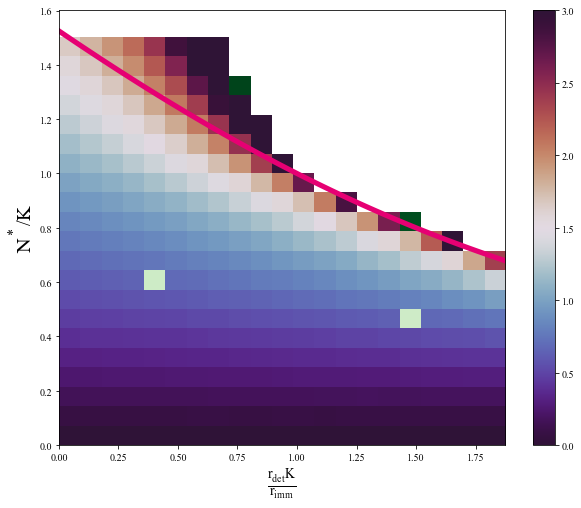

1.0004445322316002
0.9995556433513823
1.52469507659596


In [28]:
fig, ax = plt.subplots()
fig.set_size_inches((10,8))
plt.imshow(pivot, origin='lower', cmap='Greens', vmax=3, aspect='auto',
           extent=extent) # plot the unmasked one first, these squares will shine through when we then plot the masked one.
im = plt.imshow(pivot_masked, origin='lower', cmap='twilight_shifted', vmax=3, aspect='auto',
           extent=extent)

#print(det_ratio_vals)
theoryN_vals = np.vectorize(phase_diag_line_v2)(det_ratio_vals_scaled)
print(theoryN_vals[0]) #compare these to the line position to make sure it's in the correct place
print(theoryN_vals[-1])

ax.plot(det_ratio_vals_scaled, theoryN_vals, linewidth = 5.2, color="#e60073")


fig.colorbar(im)

ax.set_xlabel("$\\frac{r_{det}K}{r_{imm}}$", fontsize=20)
ax.set_ylabel("$N^*/K$", fontsize=20)

plt.show()
print(phase_diag_line_v2(0.999))
print(phase_diag_line_v2(1.001))
print(phase_diag_line_v2(0))